# Vowpal Wabbit Demo

Featuring new VW Python bindings

In [98]:
import vowpal_wabbit_next as vw
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

## Introduction

Our two dear friends Tom and Anna are visiting our news website! We want to show them articles that they would like.

In the mornings, Tom likes to read politics and Anna likes sports. In the afternoon, they favor music and politics. Can we learn their preferences?

In [99]:
USERS = ["Tom", "Anna"]
TIMES = ["morning", "afternoon"]
ACTIONS = ["politics", "sports", "music", "food", "finance", "travel", "health"]

# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

def get_cost(context, action):
    preferences = {
        "Tom": {
            "morning": "politics",
            "afternoon": "music"
        },
        "Anna": {
            "morning": "sports",
            "afternoon": "politics"
        }
    }

    user = context["user"]
    time = context["time_of_day"]
    desired = preferences[user][time]

    if action == desired:
        return USER_LIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

print("Tom, morning, politics:", get_cost({"user": "Tom", "time_of_day": "morning"}, "politics"))
print("Tom, morning, sports:", get_cost({"user": "Tom", "time_of_day": "morning"}, "sports"))

Tom, morning, politics: -1.0
Tom, morning, sports: 0.0


## Creating input to VW

Before we can leverage Vowpal Wabbit's powerful reinforcement learning capabilities, we must first convert our scenario into the VW example format.

Our shared features are name and time of day, which remain the same no matter which action we take. Each action also has a feature identifying the article's subject.

When examples are used for training, we also provide a label for the example that was chosen. This label specifies the cost (negative reward) we received and the probability at which we previously chose it.

In [100]:
# Helper function for parsing a multi-line string
def parse_lines(parser: vw.TextFormatParser, input_str: str) -> List[vw.Example]:
    return [parser.parse_line(line) for line in input_str.split("\n")]

# This function generates an example in VW format from context, actions, and an optional label (action, cost, probability)
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(
        context["user"], context["time_of_day"]
    )
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

print("Example for prediction")
print("----------------------")
print(to_vw_example_format({"user": "Tom", "time_of_day": "morning"}, ACTIONS))
print("\nExample for learning")
print("----------------------")
print(to_vw_example_format({"user": "Tom", "time_of_day": "morning"}, ACTIONS, ("politics", USER_LIKED_ARTICLE, 0.5)))

Example for prediction
----------------------
shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 
|Action article=finance 
|Action article=travel 
|Action article=health 

Example for learning
----------------------
shared |User user=Tom time_of_day=morning
0:-1.0:0.5 |Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 
|Action article=finance 
|Action article=travel 
|Action article=health 


## Running the simulation

Here's our code that sets up our simulation. On each iteration, either Tom or Anna visits at a random time.

We generate a VW example, predict, and sample an action to take from the predicted probability distribution.

We check if Tom or Anna would've liked our chosen action using the cost function we initially defined, and use this to train our VW model.

Finally, we plot a cumulative "click through rate" that shows what fraction of the time our recommended article was liked.

In [101]:
# Randomly pick Tom or Anna
def choose_user():
    return random.choice(USERS)
# Randomly pick morning or afternoon
def choose_time_of_day():
    return random.choice(TIMES)

# Given context and possible actions, predict and sample an action
def get_action(workspace: vw.Workspace, parser: vw.TextFormatParser, context):
    pmf = workspace.predict_one(
        parse_lines(parser, to_vw_example_format(context, ACTIONS))
    )
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return ACTIONS[chosen_action_index], prob

# Sample a probability distribution generated by VW
def sample_custom_pmf(pmf: List[Tuple[int, float]]) -> Tuple[int, float]:
    values = [x for (_, x) in pmf]
    total = sum(values)
    scale = 1 / total
    values = [x * scale for x in values]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(values):
        sum_prob += prob
        if sum_prob > draw:
            return pmf[index][0], prob

# Run Tom and Anna simulation for num_iterations
def run_simulation(
    workspace: vw.Workspace,
    num_iterations,
    cost_function,
    do_learn=True,
):
    cost_sum = 0.0
    ctr = []

    text_parser = vw.TextFormatParser(workspace)

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user()
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day()

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(workspace, text_parser, context)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = to_vw_example_format(context, ACTIONS, (action, cost, prob))
            # 6. Learn
            workspace.learn_one(parse_lines(text_parser, vw_format))

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr

def plot_ctr(ctr, title=None):
    plt.plot(range(1, len(ctr) + 1), ctr)
    plt.xlabel("Number of iterations", fontsize=14)
    plt.ylabel("Click through rate", fontsize=14)
    plt.ylim([0, 1])
    if title:
        plt.title(title)

## Results

For our first simulation, we create an instance of VW with the arguments `--cb_explore_adf`, `--interactions=UA`, and `--epsilon=0.1`.

We set our problem type to `--cb_explore_adf`, or contextual bandits with exploration and action-dependent features

We interact the User and Action namespaces, generating new features for each combination of features in the interacted groups.

We set `--epsilon=0.1` to perform epsilon-greedy exploration with probability 0.1.

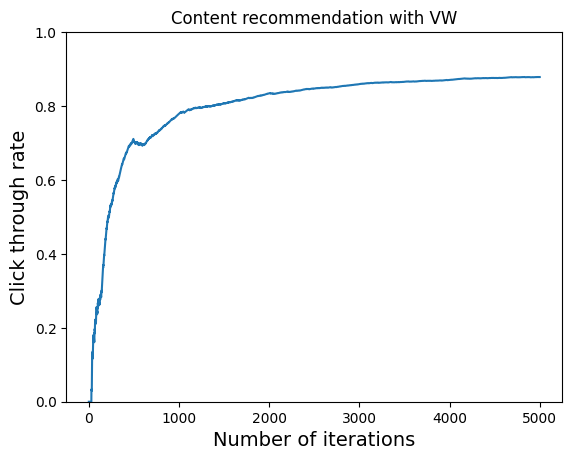

In [102]:
workspace = vw.Workspace(["--cb_explore_adf", "--interactions=UA", "--epsilon=0.1"])
num_iterations = 5000

ctr = run_simulation(workspace, num_iterations, get_cost)
plot_ctr(ctr, title="Content recommendation with VW")

To show the impact of VW's reinforcement learning, here's the same scenario without learning.

If we never have the model learn, the result is the same as randomly picking actions.

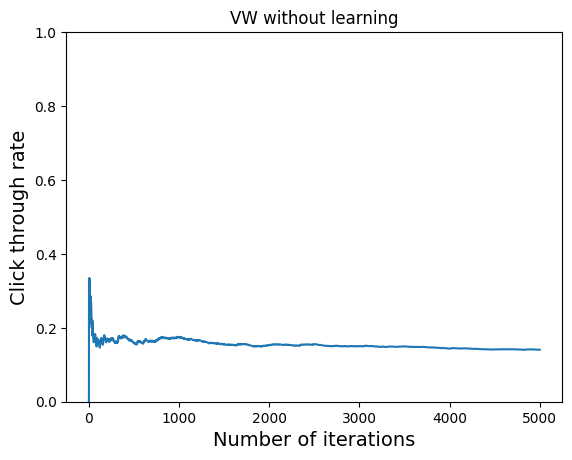

In [107]:
workspace = vw.Workspace(["--cb_explore_adf", "--interactions=UA", "--epsilon=0.1"])
num_iterations = 5000

ctr = run_simulation(workspace, num_iterations, get_cost, do_learn=False)
plot_ctr(ctr, title="VW without learning")

## The importance of feature interactions

What happens if we don't use interactions? We previously provided the argument `--interactions=UA`, which interacted the User and Action namespaces.

Let's try removing this argument. This time, our performance is not nearly as good. Without performing feature actions, VW no longer learns the effects of combining user and action features.

Instead of learning "How good is the combination of Tom and politics?", we would only try to learn the effects of having "Tom" and "politics" in isolation.

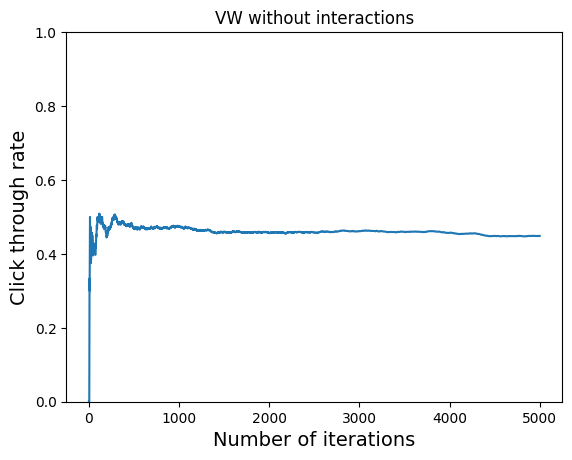

In [108]:
workspace = vw.Workspace(["--cb_explore_adf", "--epsilon=0.1"])
num_iterations = 5000

ctr = run_simulation(workspace, num_iterations, get_cost)
plot_ctr(ctr, title="VW without interactions")

## Adapting to a changing environment

Why would we want reinforcement learning instead of deploying a simpler supervised learning model? 

RL allows us to quickly adapt to a dynamic environment where preferences and rewards are constantly changing.

Suppose that Tom and Anna like politics, sports, and music today. However, tomorrow they are both feeling hungry and only want food, which is an action previously never rewarded.

To simulate this scenario, we change the reward function halfway through. VW discovers and adapts to this change, and we will see that our reward will quickly go back up.

In [105]:
def get_cost_today(context, action):
    preferences = {
        "Tom": {
            "morning": "politics",
            "afternoon": "music"
        },
        "Anna": {
            "morning": "sports",
            "afternoon": "politics"
        }
    }

    user = context["user"]
    time = context["time_of_day"]
    desired = preferences[user][time]

    if action == desired:
        return USER_LIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

def get_cost_tomorrow(context, action):
    preferences = {
        "Tom": {
            "morning": "food",
            "afternoon": "food"
        },
        "Anna": {
            "morning": "food",
            "afternoon": "food"
        }
    }

    user = context["user"]
    time = context["time_of_day"]
    desired = preferences[user][time]

    if action == desired:
        return USER_LIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

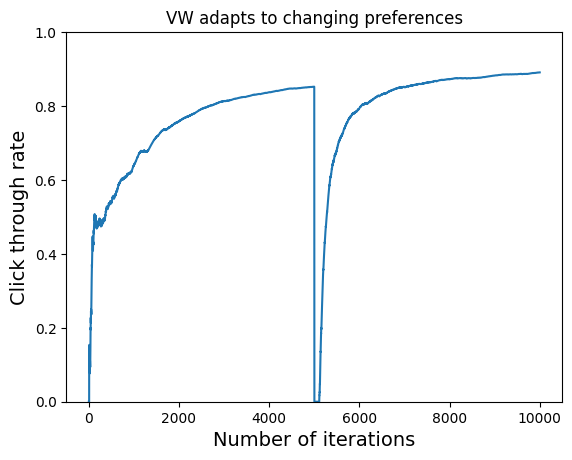

In [111]:
workspace = vw.Workspace(["--cb_explore_adf", "--interactions=UA", "--epsilon=0.1"])
num_iterations = 5000

ctr = run_simulation(workspace, num_iterations, get_cost_today)
ctr += run_simulation(workspace, num_iterations, get_cost_tomorrow)
plot_ctr(ctr, title="VW adapts to changing preferences")